# Field Validation

In [1]:

import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *
from utils.Plots import *


In [2]:
# # plot the combined data
df= pd.read_csv('../../data/test/Accelerometer_ziyi.csv')
df

,Date,NTP,GNSS-Time,Acc-X,Acc-Y,Acc-Z
0,2025-03-28T16:00:44.931,2025-03-28 16:00:48.289,1743174048272,1.781281,4.735733,8.374924
1,2025-03-28T16:00:44.935,2025-03-28 16:00:48.293,1743174048276,2.643204,5.118805,8.274368
2,2025-03-28T16:00:44.942,2025-03-28 16:00:48.300,1743174048285,2.097321,5.037399,7.814682
3,2025-03-28T16:00:44.945,2025-03-28 16:00:48.303,1743174048286,1.891418,5.061340,8.034943
4,2025-03-28T16:00:44.951,2025-03-28 16:00:48.308,1743174048292,2.892197,5.272034,7.891296
...,...,...,...,...,...,...
268724,2025-03-28T16:22:59.273,2025-03-28 16:23:02.631,1743175382614,2.863464,5.655106,7.546524
268725,2025-03-28T16:22:59.277,2025-03-28 16:23:02.636,1743175382619,2.145203,5.549759,7.067688
268726,2025-03-28T16:22:59.284,2025-03-28 16:23:02.642,1743175382625,2.815582,5.281616,8.034943
268727,2025-03-28T16:22:59.288,2025-03-28 16:23:02.646,1743175382629,2.987961,5.559341,8.226471


In [3]:
# # plot the combined data
df_curb= pd.read_csv('../../data/test/ESP_curb.csv')
# Create a list of indices to drop because not actuell curb
indices_to_drop = [0, 1, 10, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 28, 31, 35, 
                  54, 56, 62, 65, 67, 70, 74, 77, 78, 79, 80, 83, 84, 87, 89, 90,
                  92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 106, 107, 108,
                  116, 117, 120, 122, 126, 127, 128, 129, 130, 135, 136, 137, 138, 139]

# Drop the specified indices
df_curb = df_curb.drop(indices_to_drop)

# Reset the index to make it sequential again
df_curb = df_curb.reset_index(drop=True)
df_curb


,Date,NTP,GNSS-Time,Value
0,2025-03-28T16:01:49.559,2025-03-28 16:01:52.917,1743174112903,Curb Up
1,2025-03-28T16:01:56.627,2025-03-28 16:01:59.985,1743174119969,Curb Up
2,2025-03-28T16:02:06.915,2025-03-28 16:02:10.274,1743174130257,Curb Up
3,2025-03-28T16:02:20.211,2025-03-28 16:02:23.569,1743174143552,Curb Up
4,2025-03-28T16:02:41.919,2025-03-28 16:02:45.277,1743174165260,Curb Up
...,...,...,...,...
75,2025-03-28T16:21:28.435,2025-03-28 16:21:31.793,1743175291776,Curb Up
76,2025-03-28T16:22:01.715,2025-03-28 16:22:05.073,1743175325057,Curb Up
77,2025-03-28T16:22:06.616,2025-03-28 16:22:09.974,1743175329957,Curb Up
78,2025-03-28T16:22:11.213,2025-03-28 16:22:14.571,1743175334554,Curb Up


In [4]:
# set 'NTP' as time for both dataframe
# i want the eintrag in df_curb with the NTP time difference  +/-1 s as labeled as curb

In [10]:
# Convert NTP columns to datetime if not already
df_curb['NTP'] = pd.to_datetime(df_curb['NTP'])
df['NTP'] = pd.to_datetime(df['NTP'])

# Create a function to find points within ±1 second
def find_points_within_range(target_time, all_times, time_range=pd.Timedelta(seconds=1)):
    return (all_times >= target_time - time_range) & (all_times <= target_time + time_range)

# Create a mask for points within ±1s of any curb detection
mask = pd.Series(False, index=df.index)
for curb_time in df_curb['NTP']:
    mask = mask | find_points_within_range(curb_time, df['NTP'])

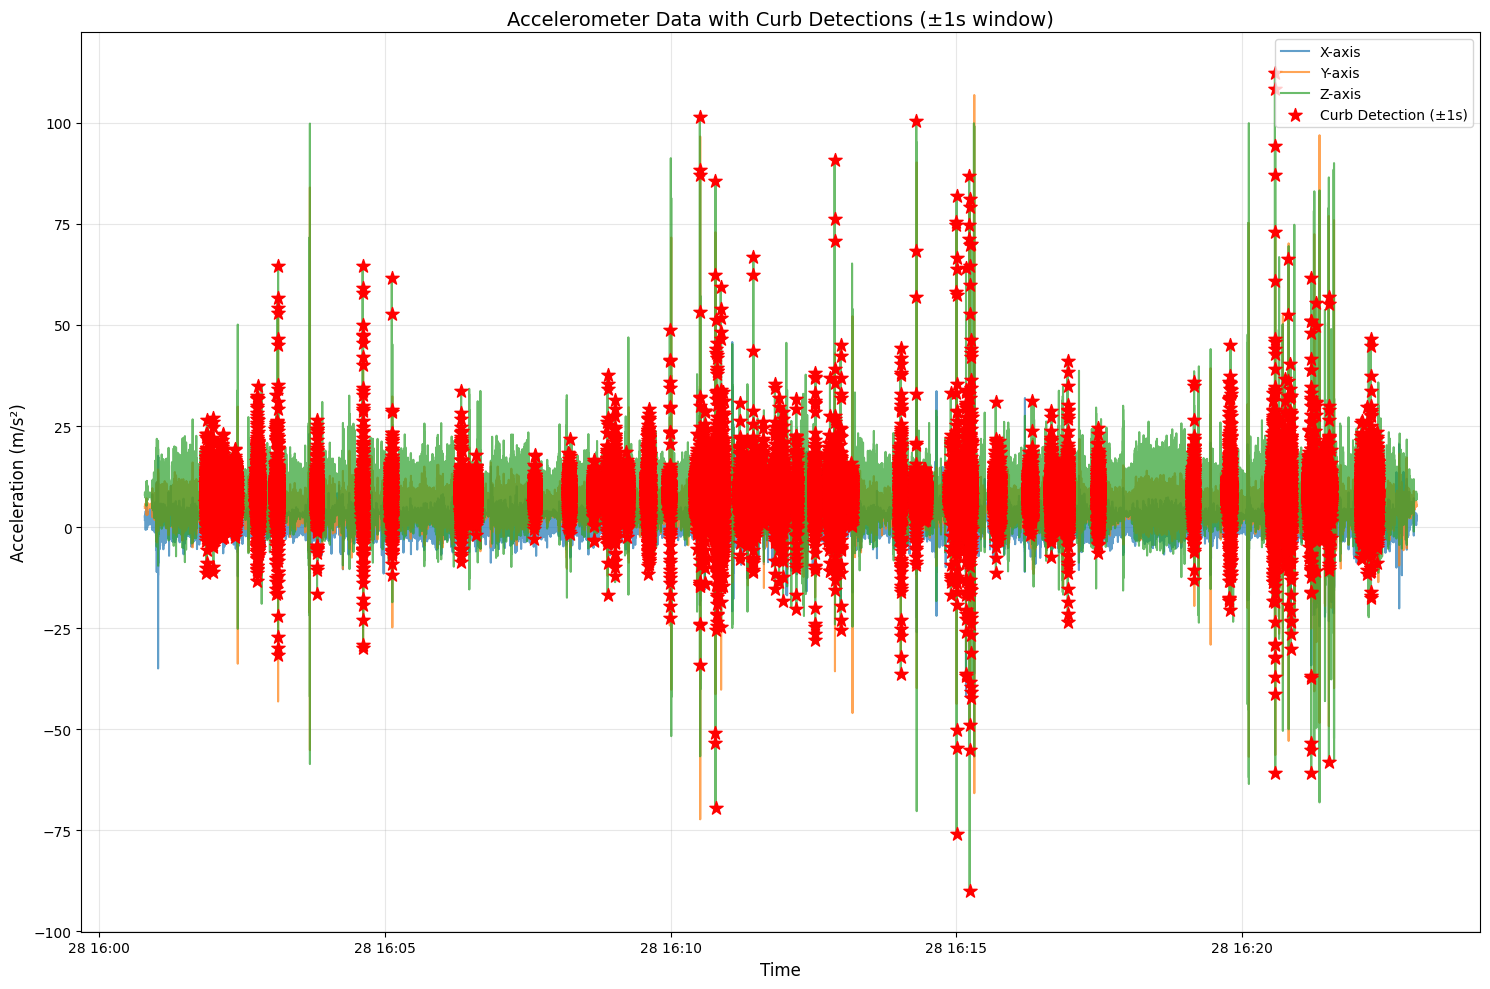

In [11]:
# Create visualization
plt.figure(figsize=(15, 10))

# Plot all accelerometer data
plt.plot(df['NTP'], df['Acc-X'], label='X-axis', alpha=0.7)
plt.plot(df['NTP'], df['Acc-Y'], label='Y-axis', alpha=0.7)
plt.plot(df['NTP'], df['Acc-Z'], label='Z-axis', alpha=0.7)

# Plot points within ±1s of curb detections
plt.scatter(df[mask]['NTP'], df[mask]['Acc-Z'], 
           color='red', marker='*', s=100, label='Curb Detection (±1s)', zorder=5)

# Customize plot
plt.title('Accelerometer Data with Curb Detections (±1s window)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Acceleration (m/s²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [12]:
# Print statistics
print(f"Total points in df: {len(df)}")
print(f"Points within ±1s of curb detections: {mask.sum()}")
print(f"Number of curb events: {len(df_curb)}")

# Create a new column in df to mark curb points
df['curb_scene'] = mask.astype(int)

# Display first few matching points
print("\nFirst few matching points:")
display(df[mask].head())

Total points in df: 268729
Points within ±1s of curb detections: 32225
Number of curb events: 80

First few matching points:


,Date,NTP,GNSS-Time,Acc-X,Acc-Y,Acc-Z,curb_scene
12814,2025-03-28T16:01:48.563,2025-03-28 16:01:51.921,1743174111904,2.456451,6.833054,6.287170,1
12815,2025-03-28T16:01:48.567,2025-03-28 16:01:51.925,1743174111909,0.790085,4.036621,10.984604,1
12816,2025-03-28T16:01:48.575,2025-03-28 16:01:51.932,1743174111917,-0.794876,2.834732,11.204864,1
12817,2025-03-28T16:01:48.577,2025-03-28 16:01:51.935,1743174111918,1.541870,5.305557,8.236053,1
12818,2025-03-28T16:01:48.585,2025-03-28 16:01:51.943,1743174111929,1.810013,6.900085,5.142746,1


In [13]:
#save
df.to_csv('../../data/test/Accelerometer_ziyi_with_curb.csv', index=False)

In [14]:
df.isnull().sum() # check for null values

Date          0
NTP           0
GNSS-Time     0
Acc-X         0
Acc-Y         0
Acc-Z         0
curb_scene    0
dtype: int64

In [15]:
#segment
output = '../../data/test/Accelerometer_ziyi_with_curb_segmented.csv'
segmented_df = segment_acceleration_data_overlapping_count_index(df,0, output)

In [16]:
segmented_df

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
0,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
0,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
0,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
0,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,2025-03-28 16:22:14.968,2025-03-28 16:22:15.460,-10.093948,1.331177,11.123459,6.268021,-2.422928,0.770935,11.631027,...,12.148178,14.556747,13.613434,5.482727,1.872269,6.837845,20.518310,14.015655,9.337387,1.240204
0,1,2025-03-28 16:22:15.465,2025-03-28 16:22:20.367,4.031830,15.437820,16.807297,14.192825,4.218582,7.848190,12.516891,...,14.106644,6.172256,5.051773,3.557785,6.229706,10.357315,8.508987,10.994171,8.973465,10.338165
0,1,2025-03-28 16:22:20.371,2025-03-28 16:22:20.863,12.636597,10.678146,4.716583,4.802765,6.756439,14.235931,12.392395,...,3.701431,2.379837,9.543289,16.409866,20.465637,8.968674,-1.613693,0.842758,9.150635,13.939041
0,1,2025-03-28 16:22:20.867,2025-03-28 16:22:21.358,10.721237,6.799530,7.105988,10.357315,13.326126,7.225708,2.494751,...,4.582504,11.511322,12.061981,5.042191,6.751648,15.251068,16.361969,12.033264,8.274368,8.025360
